# **Workflow AI Agent with Multi Tool Orchestration (RAG, Email Tool, Slack Notification Tool, Flight Booking Tool)**


✅ This sample code shows RAG is inside the Agent as a knowledge tool.
The agent is “smart” enough to both retrieve info
workflow-style AI Agent where the agent can chain multiple tools in sequence automatically.

This simulates a real enterprise orchestration:

Step 1️⃣ Look up HR leave policy (RAG).

Step 2️⃣ Summarize it.

Step 3️⃣ Send email to manager.

Step 4️⃣ Confirm delivery via Slack (simulated tool).(RAG) and take action (send email).

Fully autonomous loop agent (like AutoGPT style), where it keeps planning next steps until the workflow is done — instead of a single instruction

**Fully autonomous loop agent**
(like AutoGPT / BabyAGI style), where the agent:

*   Keeps a **plan** in memory.
*   Executes one step at a time.
*   Evaluates if the goal is achieved.
*   Decides the **next action** until completion.
*   This is a common enterprise pattern for autonomous task execution.


In [ ]:
!pip install langchain langchain-openai faiss-cpu openai
!pip install -U langchain-community
!pip install pydantic==2.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.5 MB/s eta 0:00:00
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.23.4
    Uninstalling pydantic_core-2.23.4:
      Successfully uninstalled pydantic_core-2.23.4
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.9.2
    Uninstalling pydantic-2.9.2:
      Successfully uninstalled pydantic-2.9.2


In [ ]:
import os
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_APIKEY")

import time

In [ ]:
# Load documents & create vector store (RAG setup)
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS # Import FAISS from langchain_community
from langchain.text_splitter import CharacterTextSplitter
from langchain.docstore.document import Document
from langchain.chains import RetrievalQA
from langchain.agents import initialize_agent, AgentType, tool

from pydantic import BaseModel
from typing import Optional, Dict

In [ ]:
# Example HR policy text
hr_policy = """
Employees are entitled to 20 paid leave days per year.
Unused leaves cannot be carried forward.
Sick leave requires a doctor’s certificate if more than 3 days.
"""

# Split into chunks
splitter = CharacterTextSplitter(chunk_size=200, chunk_overlap=20)
docs = splitter.split_documents([Document(page_content=hr_policy)])

In [ ]:
# Create embeddings + vector store
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
vectorstore = FAISS.from_documents(docs, embeddings)

# Create retriever for RAG
retriever = vectorstore.as_retriever()

**Define Tools**

In [ ]:
from langchain.agents import tool

# Email Tool
@tool
def send_email(to: str, subject: str, body: str):
    """Send an email to the given address with subject and body."""
    print(f"📧 Email sent to {to}\nSubject: {subject}\nBody: {body}")
    return "Email sent successfully."


In [ ]:
# Slack Notification Tool
@tool
def notify_slack(channel: str, message: str):
    """Send a Slack notification to a given channel."""
    print(f"💬 Slack message to {channel}: {message}")
    return "Slack notification sent."

In [ ]:
@tool
def hr_policy_lookup(query: str):
    """Look up HR policy details from company documents."""
    return rag_chain.run(query)

In [ ]:
# Flight Booking Tool
@tool
def book_flight(from_city: str, to_city: str, date: str, budget: int):
    """Book a flight given origin, destination, date, and budget."""
    # Fake database of flights
    flights = [
        {"airline": "AirOne", "price": 250, "from": "New York", "to": "Chicago"},
        {"airline": "SkyJet", "price": 320, "from": "New York", "to": "Chicago"},
        {"airline": "BudgetAir", "price": 180, "from": "Boston", "to": "Chicago"}
    ]
    options = [f for f in flights if f["from"] == from_city and f["to"] == to_city and f["price"] <= budget]
    if not options:
        return f"No flights found under ${budget} from {from_city} to {to_city} on {date}."
    chosen = options[0]
    return f"Booked {chosen['airline']} flight from {from_city} to {to_city} on {date} for ${chosen['price']}."


In [ ]:
# Define a Pydantic Model for Agent's Plan
class AgentAction(BaseModel):
    action: str  # hr_policy_lookup, send_email, notify_slack, FINISH
    args: Optional[Dict] = {}

In [ ]:
# Prompt the LLM to return JSON
goal = "Summarize HR leave policy, email it to manager, and confirm in Slack"
memory = [
    {"action": {"action": "hr_policy_lookup", "args": {"query": "Summarize HR leave policy"}},
     "result": "Employees get 20 paid leave days. Sick leave >3 days needs a certificate. No carry forward."},
    {"action": {"action": "send_email", "args": {"to": "manager@example.com", "subject": "HR Leave Policy Summary", "body": "..."}},
     "result": "Email sent successfully."}
]

plan_prompt = f"""
You are an autonomous agent. Your goal is: {goal}
Memory so far: {memory}

Decide the NEXT ACTION to take.
Actions: hr_policy_lookup, send_email, notify_slack, FINISH

Return ONLY a JSON object with this format:
{{"action": "action_name", "args": {{"key": "value"}}}}
"""

In [ ]:
from langchain_openai import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.agents import initialize_agent, AgentType

# Build Agent with Orchestration
# LLM
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# RAG Chain (for grounding answers)
rag_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever
)

In [ ]:
import json
import re

llm_output = llm.invoke(plan_prompt).content
# Extract first JSON object from the output
match = re.search(r"\{.*\}", llm_output, re.DOTALL)
if match:
    action_json = match.group(0)
    try:
        action_dict = json.loads(action_json)
        agent_action = AgentAction(**action_dict)
    except Exception as e:
        print("❌ JSON parsing error:", e)
        agent_action = AgentAction(action="FINISH", args={})
else:
    print("❌ No JSON found in LLM output, finishing.")
    agent_action = AgentAction(action="FINISH", args={})


In [ ]:
# Tools: RAG + Email
#tools = [
#    rag_chain.as_tool(name="hr_policy_lookup", description="Look up HR policy details"),
#    send_email,
#    notify_slack,
#    book_flight
#]

# Create AI Agent
# Use AgentType.OPENAI_FUNCTIONS which supports multi-input tools.
# Note: LangGraph's create_react_agent is the recommended approach for new implementations.
#agent = initialize_agent(
#    tools, llm,
#    agent=AgentType.OPENAI_FUNCTIONS,
#    verbose=True
#)

**Autonomous Agent Loop**

In [ ]:
def autonomous_agent(goal, max_steps=5):
    """
    A simple AutoGPT-style loop.
    The agent keeps reasoning, acting, and checking progress until the goal is done.
    """
    memory = []

    for step in range(max_steps):
        print(f"\n🌀 Step {step+1} ------------------------")

        # Agent thinks what to do next
        plan_prompt = f"""
        Goal: {goal}
        Memory so far: {memory}

        Decide the NEXT ACTION.
        Choose from: [hr_policy_lookup, send_email, notify_slack, FINISH]
        Format: ACTION: action_name | ARGS: {{...}}
        """
        action = llm.invoke(plan_prompt).content
        print("🤔 Agent decided:", action)

        # Parse decision (very simple)
        if "FINISH" in action:
            print("✅ Goal achieved.")
            break
        elif "hr_policy_lookup" in action:
            result = hr_policy_lookup.invoke({"query": "Summarize HR leave policy"})
        elif "send_email" in action:
            result = send_email.invoke({
                              "to": "manager@example.com",
                              "subject": "HR Policy",
                              "body": "body text"
                             })
        elif "notify_slack" in action:
            result = notify_slack.invoke({"channel": "#hr-updates", "message": "HR leave policy summary sent to manager@company.com."})
        elif "book_flight" in action:
            # result = book_flight("New York", "Chicago", "2023-09-15", 300)
            result = book_flight.invoke({
                              "from_city": "New York",
                              "to_city": "Chicago",
                              "date": "2023-09-15",
                              "budget": 300
                             })
        else:
            result = "Unknown action."

        print("📌 Result:", result)
        memory.append({"action": action, "result": result})
        time.sleep(2)  # avoid API rate limit


In [ ]:
# Run Autonomous Agent
autonomous_agent("Summarize HR leave policy, email it to manager, and confirm in Slack")


🌀 Step 1 ------------------------
🤔 Agent decided: ACTION: hr_policy_lookup | ARGS: {}
📌 Result: Employees are entitled to 20 paid leave days per year, and any unused leave cannot be carried forward to the next year. For sick leave, a doctor's certificate is required if the leave extends beyond 3 days.

🌀 Step 2 ------------------------
🤔 Agent decided: ACTION: send_email | ARGS: {"to": "manager@example.com", "subject": "Summary of HR Leave Policy", "body": "Employees are entitled to 20 paid leave days per year, and any unused leave cannot be carried forward to the next year. For sick leave, a doctor's certificate is required if the leave extends beyond 3 days."}
📧 Email sent to manager@example.com
Subject: HR Policy
Body: body text
📌 Result: Email sent successfully.

🌀 Step 3 ------------------------
🤔 Agent decided: ACTION: notify_slack | ARGS: {"channel": "#general", "message": "The summary of the HR leave policy has been emailed to the manager."}
💬 Slack message to #hr-updates: HR

+---------------------+
|        GOAL         |
|---------------------|
|  "Summarize HR leave|
|   policy, email it  |
|   to manager, and   |
|   confirm in Slack" |
+---------------------+
           |
           v
+---------------------+
|      AGENT LOOP     |
|---------------------|
|  1. Observe Goal    |
|  2. Read Memory     |
|     - Past actions  |
|     - Past results  |
|  3. Decide NEXT     |
|     ACTION          |
+---------------------+
           |
           v
+---------------------+
|      TOOLS          |
|---------------------|
| - hr_policy_lookup  |
| - send_email        |
| - notify_slack      |
| - (other tools)     |
+---------------------+
           |
           v
+---------------------+
|     EXECUTE TOOL    |
|---------------------|
| - Perform the action|
| - Get results       |
+---------------------+
           |
           v
+---------------------+
|      MEMORY         |
|---------------------|
| - Log action        |
| - Log result        |
+---------------------+
           |
           v
      (back to AGENT LOOP)


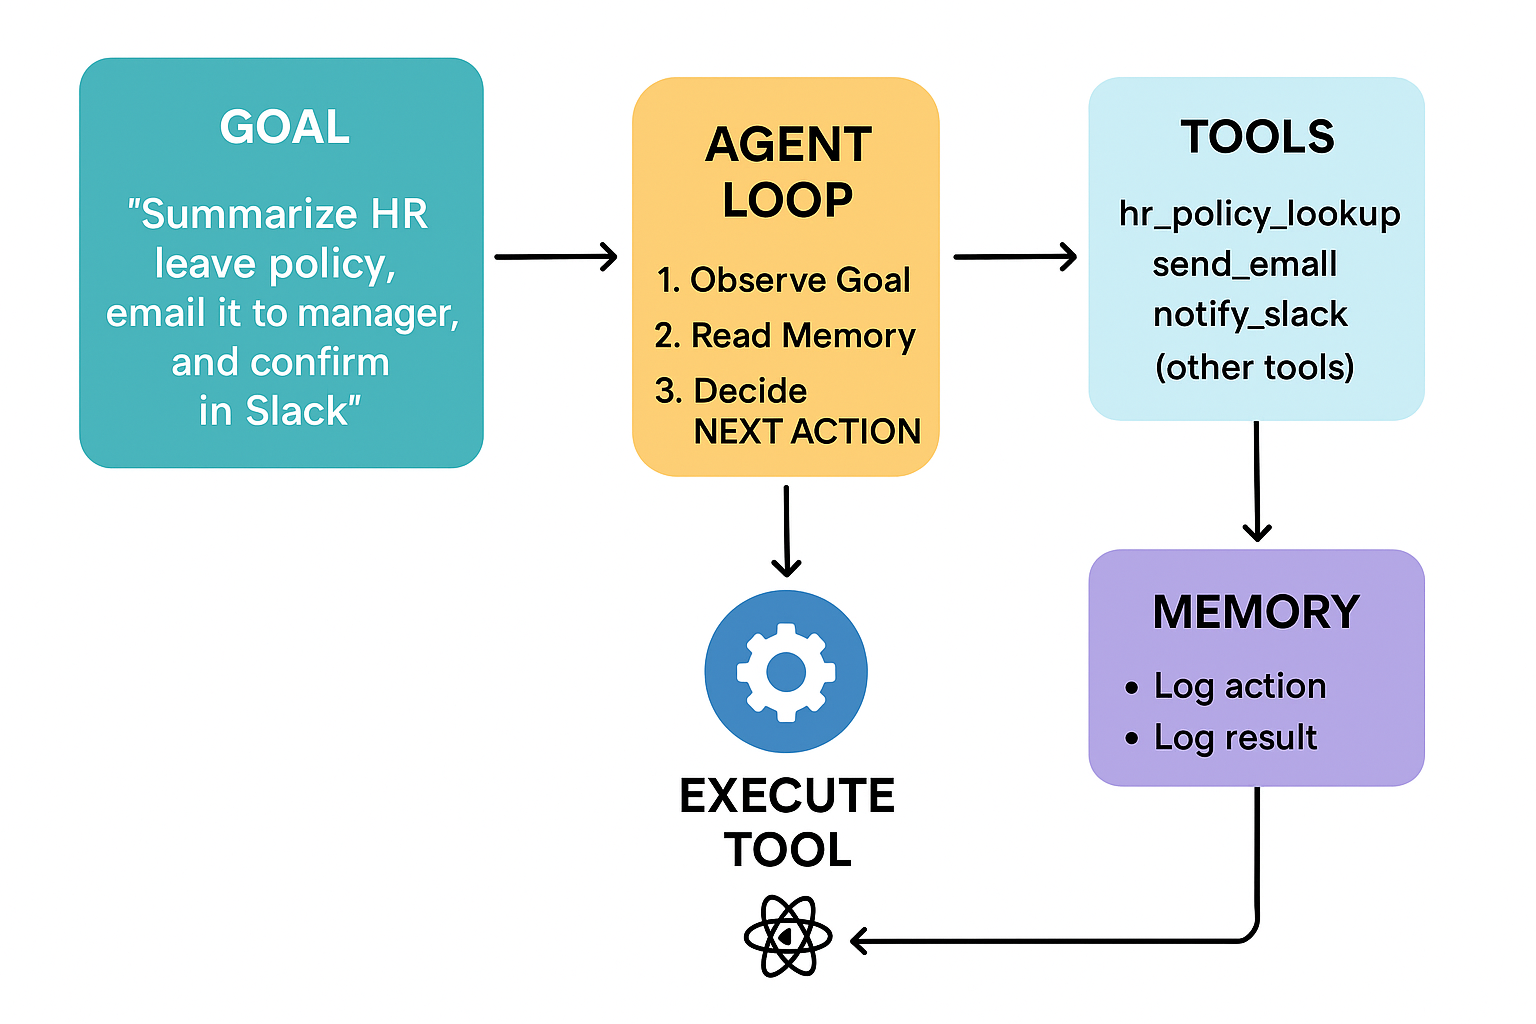

# 🔑 Explanation

1.   **Goal:** The high-level task the agent must accomplish.
2.   **Memory:** Stores all past actions and results; used to prevent repetition and plan next steps.
3.   **Agent Loop:** Uses goal + memory to decide which tool to invoke next.
4.   **Tools:** Execute the action (lookup, email, Slack, etc.).
5.   **Memory Update:** Logs the outcome so the loop can reason about the next step.

The loop continues until the agent decides the **goal is achieved** (FINISH).